In [1]:
import dill
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as transforms
import numpy as np

%run ..//JM_custom_figs.py

C:\Github\Distraction-Paper\JM_custom_figs.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence


In [2]:
datafolder = "C:\\Github\\Distraction-Paper\\data\\"
figfolder = "C:\\Github\\Distraction-Paper\\figs\\"

try:
    pickle_in = open(datafolder + "distraction_data_only_snips.pickle", 'rb')
except FileNotFoundError:
        print('Cannot access pickled file')

[modDict, disDict, habDict] = dill.load(pickle_in)

In [3]:
def average_snips(d, key, signal):
    avg_snips_out =[]
    rats = d.keys()
    for rat in rats:
        avg_snips_out.append(d[rat][key][signal])
        
    return avg_snips_out

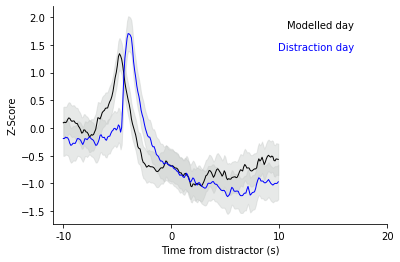

In [4]:
# difference between modelled day and distraction day

f, ax = plt.subplots()

shadedError(ax, average_snips(modDict, 'snips_distractors', 'filt_avg_z'))
shadedError(ax, average_snips(disDict, 'snips_distractors', 'filt_avg_z'), linecolor='blue')

ax.set_xlabel('Time from distractor (s)')
ax.set_xticks([0, 100, 200, 300])
ax.set_xticklabels(['-10', '0', '10', '20'])

ax.set_ylabel('Z-Score')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(0.9, 0.9, 'Modelled day', color='black', ha='right', transform=ax.transAxes)
ax.text(0.9, 0.8, 'Distraction day', color='blue', ha='right', transform=ax.transAxes)

f.savefig(figfolder+"fig3_dis-vs-model.pdf")

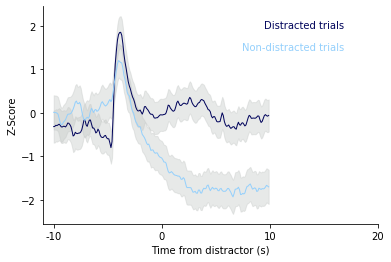

In [5]:
# difference between distracted and not-distracted trials

f, ax = plt.subplots()

shadedError(ax, average_snips(disDict, 'snips_distracted', 'filt_avg_z'), linecolor='xkcd:dark blue')
shadedError(ax, average_snips(disDict, 'snips_not-distracted', 'filt_avg_z'), linecolor='xkcd:light blue',)

ax.set_xlabel('Time from distractor (s)')
ax.set_xticks([0, 100, 200, 300])
ax.set_xticklabels(['-10', '0', '10', '20'])

ax.set_ylabel('Z-Score')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(0.9, 0.9, 'Distracted trials', color='xkcd:dark blue', ha='right', transform=ax.transAxes)
ax.text(0.9, 0.8, 'Non-distracted trials', color='xkcd:light blue', ha='right', transform=ax.transAxes)

f.savefig(figfolder+"fig4_dis-vs-non-dis.pdf")

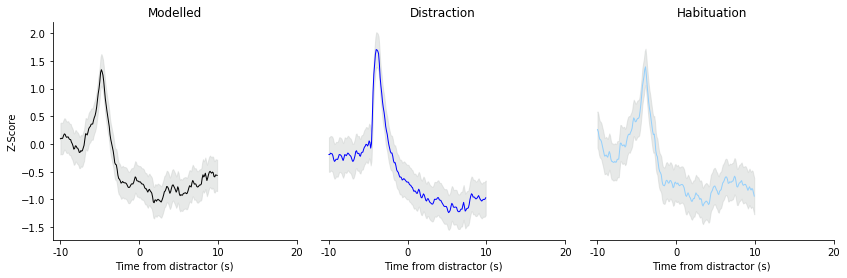

In [15]:
# aligned to distrator on all three days

f, ax = plt.subplots(ncols=3, figsize=(14,4))

# sets space between plots
f.subplots_adjust(wspace=0.1)

shadedError(ax[0], average_snips(modDict, 'snips_distractors', 'filt_avg_z'))
shadedError(ax[1], average_snips(disDict, 'snips_distractors', 'filt_avg_z'), linecolor='blue')
shadedError(ax[2], average_snips(habDict, 'snips_distractors', 'filt_avg_z'), linecolor='xkcd:light blue')

# adds y label to left hand plot
ax[0].set_ylabel('Z-Score')

# applies settings to all axes
for axis in ax:
    axis.set_xlabel('Time from distractor (s)')
    axis.set_xticks([0, 100, 200, 300])
    axis.set_xticklabels(['-10', '0', '10', '20'])
    
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    
    axis.set_ylim(ax[1].get_ylim())

# turns of axis and ticks from middle and right plots
for axis in [ax[1], ax[2]]:
    axis.spines['left'].set_visible(False)
    axis.set_yticks([])

# adds titles to plots    
ax[0].set_title('Modelled')
ax[1].set_title('Distraction')
ax[2].set_title('Habituation')


f.savefig(figfolder+"fig3_distractor on all days.pdf")

In [7]:
def get_auc_or_peak(d, key, signal, bins=[100, 130], calctype='auc'):
    
    all_trials = []
    mean = []
    
    rats = d.keys()
    for rat in rats:
        snip = d[rat][key][signal]
        rat_trials = []
        for trial in snip:
            if calctype == 'auc':
                rat_trials.append(np.trapz(trial[bins[0]:bins[1]])*0.1) # multiplies by 0.1 because of 10 Hz sample rate, output is Z per second
            elif calctype == 'peak':
                rat_trials.append(np.max(trial[bins[0]:bins[1]]))
            else:
                print('Not a valid calculation type. Try peak or auc')
                return [], []
            
        all_trials.append(rat_trials)
        mean.append(np.mean(rat_trials))

    return all_trials, mean

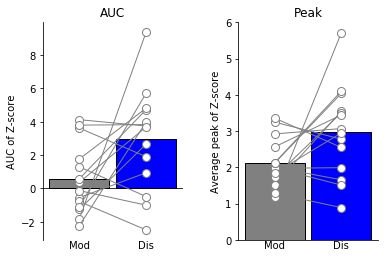

In [12]:
# To make peak and AUC comparison for modelled and distractor day

colors = ['grey','blue']

bins=[100, 130]
# For use with shorter snip length
bins=[50, 80]

f, ax = plt.subplots(ncols=2)
f.subplots_adjust(wspace=0.4)

avg_auc_mod = get_auc_or_peak(modDict, 'snips_distractors', 'filt_z', bins=bins)[1]
avg_auc_dis = get_auc_or_peak(disDict, 'snips_distractors', 'filt_z', bins=bins)[1]

barscatter([avg_auc_mod, avg_auc_dis], paired=True,
           barfacecolor=colors, barfacecoloroption='individual',
           ax=ax[0])

avg_peak_mod = get_auc_or_peak(modDict, 'snips_distractors', 'filt_z', calctype='peak', bins=bins)[1]
avg_peak_dis = get_auc_or_peak(disDict, 'snips_distractors', 'filt_z', calctype='peak', bins=bins)[1]

barscatter([avg_peak_mod, avg_peak_dis], paired=True,
           barfacecolor=colors, barfacecoloroption='individual',
           ax=ax[1])

ax[0].set_title('AUC')
ax[0].set_ylabel('AUC of Z-score')

ax[1].set_title('Peak')
ax[1].set_ylabel('Average peak of Z-score')
#ax[1].set_ylim([-0.3, 3.9])

for axis in ax:
    
    trans = transforms.blended_transform_factory(axis.transData, axis.transAxes)
    
    axis.set_xticks([1,2])
    axis.set_xticklabels(['Mod', 'Dis'], va='top', transform=trans)
    
f.savefig(figfolder+"fig3_distractor_auc and peak.pdf")


Ttest_relResult(statistic=1.6171641328069282, pvalue=0.12983888233644703)

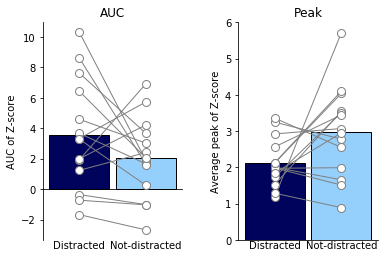

In [13]:
# To make peak and AUC comparison for distracted and non-distracted trials

colors = ['xkcd:dark blue','xkcd:light blue']

bins=[100, 130]
# For use with shorter snip length
bins=[50, 80]

f, ax = plt.subplots(ncols=2)
f.subplots_adjust(wspace=0.4)

avg_auc_d = get_auc_or_peak(disDict, 'snips_distracted', 'filt_z', bins=bins)[1]
avg_auc_nd = get_auc_or_peak(disDict, 'snips_not-distracted', 'filt_z', bins=bins)[1]

barscatter([avg_auc_d, avg_auc_nd], paired=True,
           barfacecolor=colors, barfacecoloroption='individual',
           ax=ax[0])

avg_peak_d = get_auc_or_peak(disDict, 'snips_distracted', 'filt_z', calctype='peak', bins=bins)[1]
avg_peak_nd = get_auc_or_peak(disDict, 'snips_not-distracted', 'filt_z', calctype='peak', bins=bins)[1]

barscatter([avg_peak_mod, avg_peak_dis], paired=True,
           barfacecolor=colors, barfacecoloroption='individual',
           ax=ax[1])

ax[0].set_title('AUC')
ax[0].set_ylabel('AUC of Z-score')

ax[1].set_title('Peak')
ax[1].set_ylabel('Average peak of Z-score')
#ax[1].set_ylim([-0.3, 3.9])

for axis in ax:
    
    trans = transforms.blended_transform_factory(axis.transData, axis.transAxes)
    
    axis.set_xticks([1,2])
    axis.set_xticklabels(['Distracted', 'Not-distracted'], va='top', transform=trans)
    
f.savefig(figfolder+"fig4_distracted vs nd_auc and peak.pdf")


In [ ]:
rat = 'thph1.1'
d = disDict[rat]

snips 
